In [3]:
import os
import shutil
import glob
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, SpatialDropout2D,  BatchNormalization,Conv2DTranspose, concatenate,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras import backend as K

from tensorflow.keras.layers import Dense, Dropout


In [4]:
from Spatial_Attention import *

In [5]:
# Veri dizinleri
data_folder = r"C:\Users\Desktop\veri"

In [6]:
train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")
validation_folder = os.path.join(data_folder, "validation")

In [7]:
#####Train
train_data = []
train_mask = []

for patient_folder in glob.glob(os.path.join(train_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        train_data.append(image)
        train_mask.append(mask)

# Veri --> numpy
train_data = np.array(train_data, dtype=object)
train_mask = np.array(train_mask, dtype=object)

#####Test
test_data = []
test_mask = []

for patient_folder in glob.glob(os.path.join(test_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        test_data.append(image)
        test_mask.append(mask)

# Veri --> numpy
test_data = np.array(test_data, dtype=object)
test_mask = np.array(test_mask, dtype=object)

#####Validation
validation_data = []
validation_mask = []

for patient_folder in glob.glob(os.path.join(validation_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    for image_path in glob.glob(os.path.join(image_folder, "*.png")):
        image = cv2.imread(image_path)
        validation_data.append(image)

    for mask_path in glob.glob(os.path.join(mask_folder, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        validation_mask.append(mask)

# Veri --> numpy
validation_data = np.array(validation_data, dtype=object)
validation_mask = np.array(validation_mask, dtype=object)


print("Eğitim verilerinin boyutu:", train_data.shape)
print("Eğitim maskelerinin boyutu:", train_mask.shape)
print("Test verilerinin boyutu:", test_data.shape)
print("Test maskelerinin boyutu:", test_data.shape)
print("validation verilerinin boyutu:", validation_data.shape)
print("validation maskelerinin boyutu:", validation_mask.shape)

Eğitim verilerinin boyutu: (1944,)
Eğitim maskelerinin boyutu: (1944,)
Test verilerinin boyutu: (282,)
Test maskelerinin boyutu: (282,)
validation verilerinin boyutu: (283,)
validation maskelerinin boyutu: (283,)


In [8]:
new_width = 128
new_height = 128

#Train

resized_train_data = []
for image in train_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_train_data.append(normalized_image)

resized_train_data = np.array(resized_train_data)

resized_train_mask = []
for mask in train_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask/255.0
    resized_train_mask.append(resized_mask)
resized_train_mask = np.array(resized_train_mask)

resized_train_mask = resized_train_mask.reshape(-1, 128, 128, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu:", resized_train_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu:", resized_train_mask.shape)

#Test

resized_test_data = []

for image in test_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_test_data.append(normalized_image)

resized_test_data = np.array(resized_test_data)

resized_test_mask = []

for mask in test_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask / 255.0
    resized_test_mask.append(resized_mask)

resized_test_mask = np.array(resized_test_mask)
resized_test_mask = resized_test_mask.reshape(-1, new_width, new_height, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu:", resized_test_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu:", resized_test_mask.shape)

#Validation

resized_validation_data = []
for image in validation_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_validation_data.append(normalized_image)

resized_validation_data = np.array(resized_validation_data)

resized_validation_mask = []
for mask in validation_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    normalized_mask = resized_mask / 255.0
    resized_validation_mask.append(normalized_mask)
resized_validation_mask = np.array(resized_validation_mask)
resized_validation_mask = resized_validation_mask.reshape(-1, new_width, new_height, 1)

print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu:", resized_validation_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu:", resized_validation_mask.shape)


Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu: (1944, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu: (1944, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu: (282, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu: (282, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu: (283, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu: (283, 128, 128, 1)


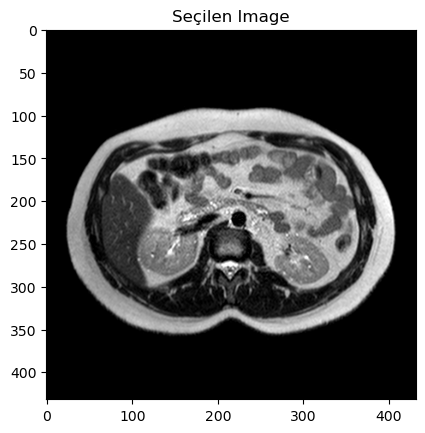

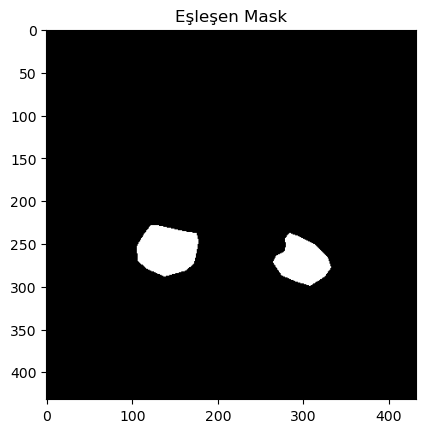

In [7]:
# Rastgele bir hastayı ve image/mask çiftini seçme
random_patient_folder = random.choice(glob.glob(os.path.join(train_folder, "patient")))
image_folder = os.path.join(random_patient_folder, "image")
mask_folder = os.path.join(random_patient_folder, "mask")

# image ve mask dosyalarını listeleme
image_files = glob.glob(os.path.join(image_folder, "*.png"))
mask_files = glob.glob(os.path.join(mask_folder, "*.png"))

# Rastgele bir image seçme
random_image_path = random.choice(image_files)
random_image = cv2.imread(random_image_path)

# Seçilen image ile hangi mask dosyasının eşleştiğini bulma
image_name = os.path.basename(random_image_path)
image_id = os.path.splitext(image_name)[0]
matching_mask_path = os.path.join(mask_folder, f"{image_id}.png")

# Eşleşen mask dosyasını yükleme
matching_mask = cv2.imread(matching_mask_path, cv2.IMREAD_GRAYSCALE)

# Seçilen Image'i görüntüleme
plt.imshow(random_image)
plt.title("Seçilen Image")
plt.show()

# Eşleşen mask'ı uygun bir NumPy dizisine dönüştürme
matching_mask = np.array(matching_mask, dtype=np.uint8)

plt.imshow(matching_mask, cmap='gray')
plt.title("Eşleşen Mask")
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma parametrelerini belirle
datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme (0 ile belirtilen derece arasında)
    #width_shift_range=0.2,  # Genişlik yönlü kayma
    #height_shift_range=0.2, # Yükseklik yönlü kayma
    shear_range=0.2,        # Kesme etkisi
    zoom_range=0.2,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    vertical_flip=True,     # Dikey çevirme
    fill_mode='nearest',     # Eksik pikselleri doldurma yöntemi  
)

# Eğitim verisi ve maskeleri için veri artırma uygula
augmented_train_data = []
augmented_train_mask = []

for i in range(len(resized_train_data)):
    img = resized_train_data[i]
    mask = resized_train_mask[i]

    img = img.reshape((1,) + img.shape)  # Veri artırma işlemi genellikle batch olarak yapılır
    mask = mask.reshape((1,) + mask.shape)

    seed = np.random.randint(1, 1000)
    img_gen = datagen.flow(img, batch_size=1, seed=seed)
    mask_gen = datagen.flow(mask, batch_size=1, seed=seed)

    augmented_train_data.append(img_gen[0][0])
    augmented_train_mask.append(mask_gen[0][0])

augmented_train_data = np.array(augmented_train_data)
augmented_train_mask = np.array(augmented_train_mask)

# Veri artırma sonrası boyutları kontrol et
print("Veri artırma sonrası eğitim verilerinin boyutu:", augmented_train_data.shape)
print("Veri artırma sonrası eğitim maskelerinin boyutu:", augmented_train_mask.shape)


Veri artırma sonrası eğitim verilerinin boyutu: (1944, 128, 128, 3)
Veri artırma sonrası eğitim maskelerinin boyutu: (1944, 128, 128, 1)


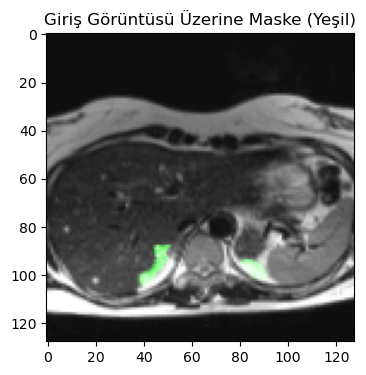

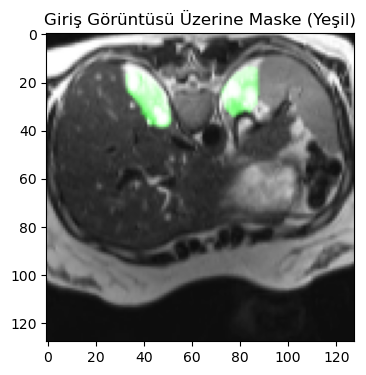

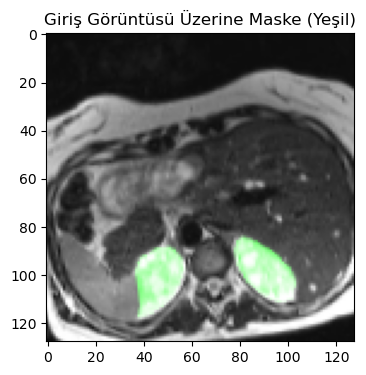

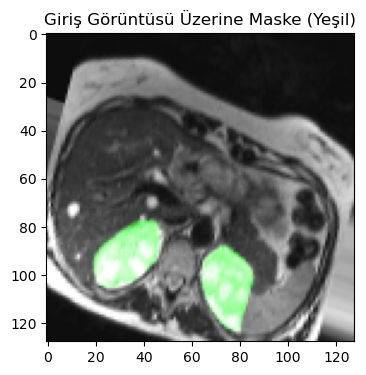

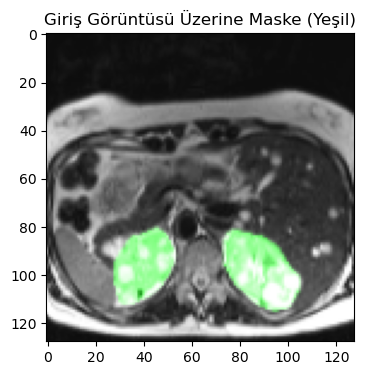

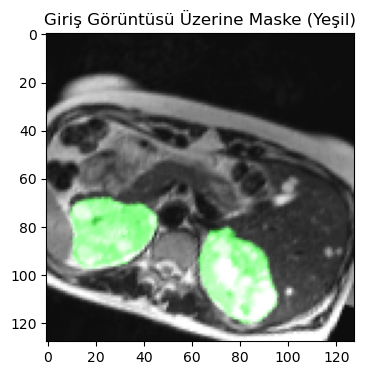

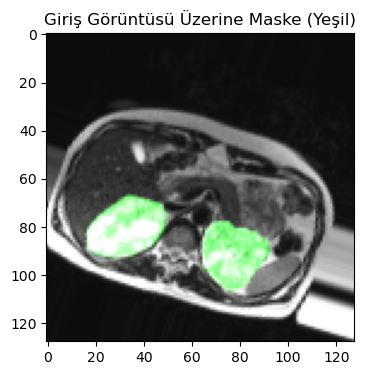

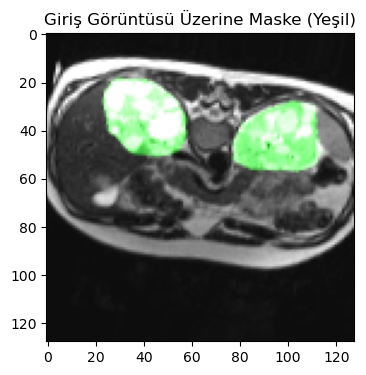

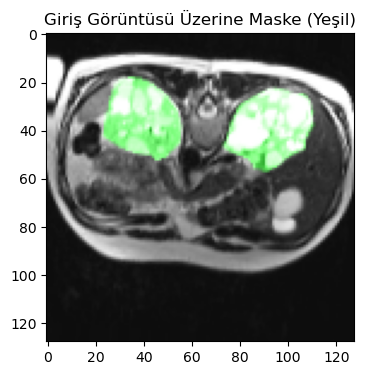

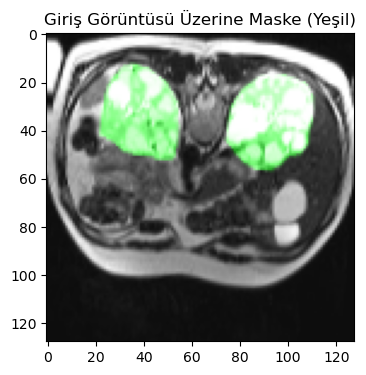

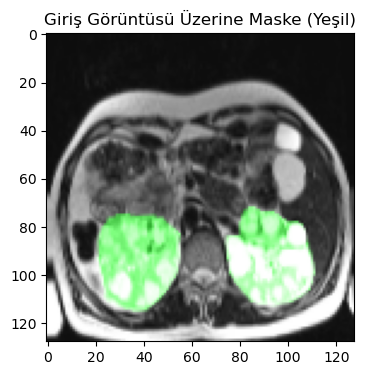

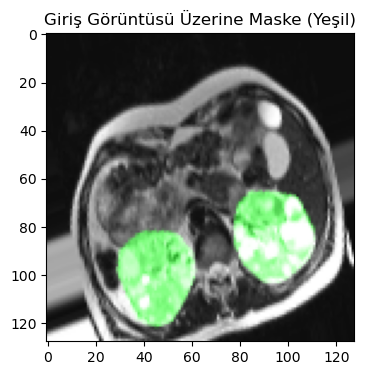

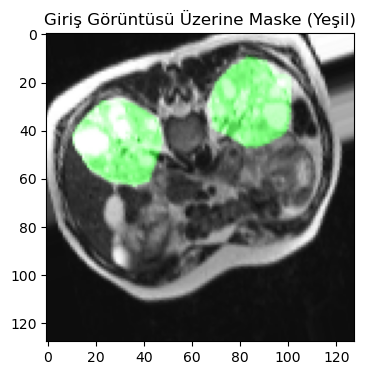

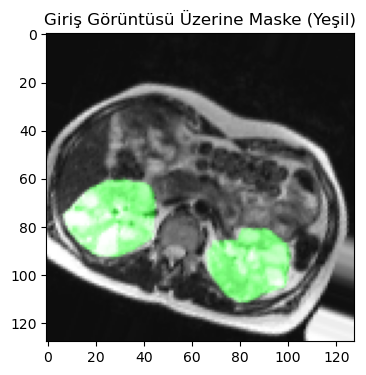

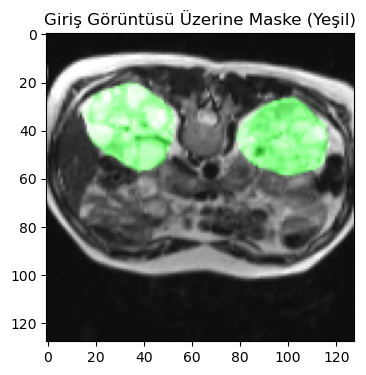

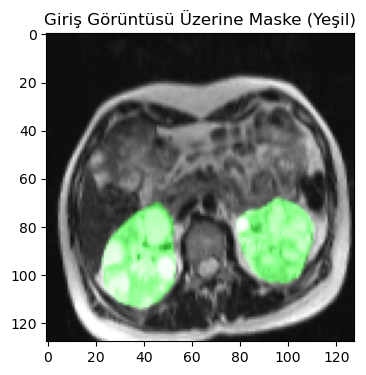

In [8]:
# İlk 16 artırılmış görüntü ve maskeleri alın
sample_images = augmented_train_data[:16]
sample_masks = augmented_train_mask[:16]

# Her bir örneği görselleştirme
for i in range(16):
    input_image = (sample_images[i] * 255).astype(np.uint8)  # Giriş görüntüsünü 0-255 aralığına geri getir
    real_mask = (sample_masks[i] * 255).astype(np.uint8).reshape(new_height, new_height)

    # Renkli maskeyi oluştur
    colored_mask = cv2.cvtColor(real_mask, cv2.COLOR_GRAY2RGB)
    colored_mask[:,:,0] = 0  # Mavi kanalı sıfır yap
    colored_mask[:,:,2] = 0  # Kırmızı kanalı sıfır yap

    # Giriş görüntüsü ve üstüne maskenin eklenmesi
    overlay = cv2.addWeighted(input_image, 1, colored_mask, 0.5, 0)

    # Görselleştirme
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 1, 1)
    plt.imshow(overlay)
    plt.title('Giriş Görüntüsü Üzerine Maske (Yeşil)')

    plt.show()


In [10]:
# Orijinal ve artırılmış verileri birleştirme
combined_train_data = np.concatenate((resized_train_data, augmented_train_data), axis=0)
combined_train_mask = np.concatenate((resized_train_mask, augmented_train_mask), axis=0)

# Veri birleştirme sonrası boyutları kontrol et
print("Birleştirilmiş eğitim verilerinin boyutu:", combined_train_data.shape)
print("Birleştirilmiş eğitim maskelerinin boyutu:", combined_train_mask.shape)

Birleştirilmiş eğitim verilerinin boyutu: (3888, 128, 128, 3)
Birleştirilmiş eğitim maskelerinin boyutu: (3888, 128, 128, 1)


In [9]:
#batch_size = 16

img_height = 128
img_width = 128
img_channel = 3

In [10]:
class DropBlock2D(layers.Layer):
    def __init__(self, keep_prob, block_size, **kwargs):
        super(DropBlock2D, self).__init__(**kwargs)
        self.keep_prob = keep_prob
        self.block_size = block_size

    def call(self, inputs, training=None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 3, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], shape[2], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 3, 1, 2])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)

    def get_config(self):
        config = super(DropBlock2D, self).get_config()
        config['keep_prob'] = self.keep_prob
        config['block_size'] = self.block_size
        return config

In [11]:
def SA_UNet(input_size=(128, 128, 3), block_size=7,keep_prob=0.9,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = SpatialDropout2D(rate=0.2)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = SpatialDropout2D(rate=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = SpatialDropout2D(rate=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = SpatialDropout2D(rate=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = SpatialDropout2D(rate=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = SpatialDropout2D(rate=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = SpatialDropout2D(rate=0.2)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = SpatialDropout2D(rate=0.2)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = SpatialDropout2D(rate=0.2)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = SpatialDropout2D(rate=0.2)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = SpatialDropout2D(rate=0.2)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = SpatialDropout2D(rate=0.2)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = SpatialDropout2D(rate=0.2)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = SpatialDropout2D(rate=0.2)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs, output_layer, name="SA-UNet")

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
SA_UNet_model = SA_UNet(input_size=(128, 128, 3))  # Modeli oluştur
SA_UNet_model.summary()  # Modelin özetini yazdır


Model: "SA-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 128, 128, 16  0          ['conv2d[0][0]']                 
 out2D)                         )                                                           

                                                                                                  
 activation_6 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 lambda (Lambda)                (None, 16, 16, 1)    0           ['activation_6[0][0]']           
                                                                                                  
 lambda_1 (Lambda)              (None, 16, 16, 1)    0           ['activation_6[0][0]']           
                                                                                                  
 concatenate (Concatenate)      (None, 16, 16, 2)    0           ['lambda[0][0]',                 
                                                                  'lambda_1[0][0]']               
                                                                                                  
 conv2d_7 

C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 32)  18464       ['activation_9[0][0]']           
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 64)   0           ['conv2d_transpose_1[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 32)   18464       ['concatenate_2[0][0]']          
          

In [13]:
#custom loss and metrics functions
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2)) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    precision = (intersection + smooth) / (K.sum(y_pred, axis=(1, 2)) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true, axis=(1, 2)) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall)
    return K.mean(f1)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def scheduler(epoch, lr):
      if epoch < 30:
        lr = 0.001
        return lr
      if epoch < 50:
        return 0.0005
      return 0.0001

# k-fold

In [13]:
from sklearn.model_selection import KFold

# K-Fold Cross Validation için KFold nesnesini oluşturun
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_loss, all_val_loss, all_train_acc, all_val_acc = [], [], [], []

fold = 0

for train_index, test_index in kf.split(resized_train_data, resized_train_mask):
    fold += 1
    print(f"Fold {fold}:")

    # Eğitim ve test setlerini oluşturun
    X_train_fold, X_test_fold = resized_train_data[train_index], resized_train_data[test_index]
    y_train_fold, y_test_fold = resized_train_mask[train_index], resized_train_mask[test_index]

    # Yeni bir model oluşturun (her fold için yeni bir model)
    SA_UNet_model = SA_UNet((img_height, img_width, 3))

    # Modeli derle
    SA_UNet_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', F1, recall, precision, dice_coef, iou])

    # Modeli eğitin
    history = SA_UNet_model.fit(X_train_fold, 
                              y_train_fold, 
                              epochs=10, 
                              batch_size=32, 
                              verbose=1)

    # Modeli test edin
    test_results = SA_UNet_model.evaluate(X_test_fold, y_test_fold, batch_size=32)

    # Eğitim ve validation loss/accuracy değerlerini kaydedin
    all_train_loss.append(history.history['loss'])
    all_train_acc.append(history.history['accuracy'])
    all_val_loss.append(test_results[0])  # test_results içinde loss değeri 0. indexte
    all_val_acc.append(test_results[1])   # test_results içinde accuracy değeri 1. indexte


Fold 1:
Epoch 1/10


C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/43 [==============================] - 47s 1s/step - loss: 0.4963 - accuracy: 0.8673 - F1: 0.1268 - recall: 0.4726 - precision: 0.2381 - dice_coef: 0.1339 - iou: 0.0697
Epoch 2/10
43/43 [==============================] - 46s 1s/step - loss: 0.2896 - accuracy: 0.9498 - F1: 0.1709 - recall: 0.3390 - precision: 0.5500 - dice_coef: 0.1815 - iou: 0.0972
Epoch 3/10
43/43 [==============================] - 46s 1s/step - loss: 0.2048 - accuracy: 0.9628 - F1: 0.2422 - recall: 0.4995 - precision: 0.7221 - dice_coef: 0.2617 - iou: 0.1447
Epoch 4/10
43/43 [==============================] - 46s 1s/step - loss: 0.1563 - accuracy: 0.9691 - F1: 0.3155 - recall: 0.6151 - precision: 0.7643 - dice_coef: 0.3420 - iou: 0.1976
Epoch 5/10
43/43 [==============================] - 45s 1s/step - loss: 0.1277 - accuracy: 0.9720 - F1: 0.3689 - recall: 0.6603 - precision: 0.7855 - dice_coef: 0.4032 - iou: 0.2393
Epoch 6/10
43/43 [==============================] - 46s 1s/step - loss: 0.1086 - accuracy: 0.9736 - F

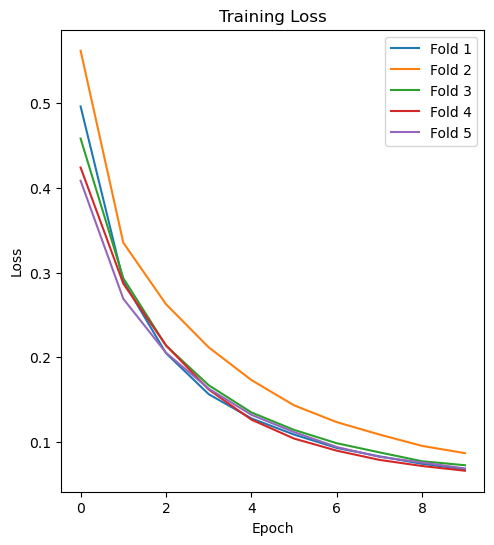

In [14]:
# Eğitim ve validation loss grafiği çizin
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(all_train_loss[i], label=f'Fold {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# grid search

In [12]:
from sklearn.model_selection import ParameterGrid

In [13]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 5e-3, 1e-4],
    'batch_size': [ 64],
    'epochs': [80]
}
# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))


In [21]:
def build_compile_SA_UNet(input_shape, learning_rate):
    SA_UNet_model = SA_UNet(input_shape)
    SA_UNet_model.compile(optimizer=Adam(learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy', F1, recall, precision, dice_coef, iou])
    return SA_UNet_model

In [22]:
best_model = None
best_dice_coefficient = 0

In [13]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 5e-3, 1e-4],
    'batch_size': [ 64],
    'epochs': [80]
}
# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))
def build_compile_SA_UNet(input_shape, learning_rate):
    SA_UNet_model = SA_UNet(input_shape)
    SA_UNet_model.compile(optimizer=Adam(learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy', F1, recall, precision, dice_coef, iou])
    return SA_UNet_model
input_shape = (img_height, img_width, img_channel)

best_model = None
best_dice_coefficient = 0

for params in param_combinations:
    print(f"\nTraining with hyperparameters: {params}")

    # Build and compile model
 
    SA_UNet_model = SA_UNet(input_shape)
    SA_UNet_model = build_compile_SA_UNet(input_shape, params['learning_rate'])

    # Train the model
    history = SA_UNet_model.fit(
        resized_train_data,
        resized_train_mask,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(resized_validation_data, resized_validation_mask),
        verbose=2
    )
    
    # Evaluate the model on validation data
    eval_metrics = SA_UNet_model.evaluate(resized_validation_data, resized_validation_mask, verbose=0)
    
    # Assuming 'dice_coef' is the metric at index 5
    dice_coefficient = eval_metrics[5]
    print(f"Validation dice coefficient: {dice_coefficient}")

    if dice_coefficient > best_dice_coefficient:
        best_dice_coefficient = dice_coefficient
        best_model = SA_UNet_model

print("\nBest Hyperparameters:")
#print(best_model.get_config())


Training with hyperparameters: {'batch_size': 64, 'epochs': 80, 'learning_rate': 0.001}


C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
27/27 - 117s - loss: 0.3684 - accuracy: 0.9152 - F1: 0.1309 - recall: 0.3240 - precision: 0.2595 - dice_coef: 0.1397 - iou: 0.0722 - val_loss: 0.5601 - val_accuracy: 0.9165 - val_F1: 0.0334 - val_recall: 0.5853 - val_precision: 0.1026 - val_dice_coef: 0.0340 - val_iou: 0.0172 - 117s/epoch - 4s/step
Epoch 2/80
27/27 - 106s - loss: 0.2639 - accuracy: 0.9373 - F1: 0.1550 - recall: 0.2882 - precision: 0.3899 - dice_coef: 0.1688 - iou: 0.0870 - val_loss: 0.2682 - val_accuracy: 0.9841 - val_F1: 0.0354 - val_recall: 0.0051 - val_precision: 0.4953 - val_dice_coef: 0.0364 - val_iou: 0.0182 - 106s/epoch - 4s/step
Epoch 3/80
27/27 - 136s - loss: 0.2039 - accuracy: 0.9517 - F1: 0.2171 - recall: 0.4267 - precision: 0.5706 - dice_coef: 0.2387 - iou: 0.1285 - val_loss: 0.1235 - val_accuracy: 0.9819 - val_F1: 0.0910 - val_recall: 0.3762 - val_precision: 0.3947 - val_dice_coef: 0.1014 - val_iou: 0.0494 - 136s/epoch - 5s/step
Epoch 4/80
27/27 - 117s - loss: 0.1576 - accuracy: 0.9637 - F1: 0.2

Epoch 28/80
27/27 - 99s - loss: 0.0388 - accuracy: 0.9846 - F1: 0.6907 - recall: 0.8466 - precision: 0.8730 - dice_coef: 0.7627 - iou: 0.5575 - val_loss: 0.0492 - val_accuracy: 0.9825 - val_F1: 0.4247 - val_recall: 0.8224 - val_precision: 0.4561 - val_dice_coef: 0.4854 - val_iou: 0.2959 - 99s/epoch - 4s/step
Epoch 29/80
27/27 - 103s - loss: 0.0372 - accuracy: 0.9855 - F1: 0.6996 - recall: 0.8554 - precision: 0.8815 - dice_coef: 0.7732 - iou: 0.5680 - val_loss: 0.0586 - val_accuracy: 0.9787 - val_F1: 0.4133 - val_recall: 0.8846 - val_precision: 0.4024 - val_dice_coef: 0.4675 - val_iou: 0.2839 - 103s/epoch - 4s/step
Epoch 30/80
27/27 - 103s - loss: 0.0373 - accuracy: 0.9851 - F1: 0.7021 - recall: 0.8521 - precision: 0.8780 - dice_coef: 0.7728 - iou: 0.5708 - val_loss: 0.0395 - val_accuracy: 0.9857 - val_F1: 0.4507 - val_recall: 0.7849 - val_precision: 0.5194 - val_dice_coef: 0.5242 - val_iou: 0.3192 - 103s/epoch - 4s/step
Epoch 31/80
27/27 - 114s - loss: 0.0360 - accuracy: 0.9855 - F1: 0

Epoch 55/80
27/27 - 103s - loss: 0.0257 - accuracy: 0.9885 - F1: 0.7849 - recall: 0.8857 - precision: 0.9105 - dice_coef: 0.8456 - iou: 0.6708 - val_loss: 0.0541 - val_accuracy: 0.9817 - val_F1: 0.4755 - val_recall: 0.8910 - val_precision: 0.4451 - val_dice_coef: 0.5384 - val_iou: 0.3428 - 103s/epoch - 4s/step
Epoch 56/80
27/27 - 101s - loss: 0.0253 - accuracy: 0.9886 - F1: 0.7868 - recall: 0.8893 - precision: 0.9089 - dice_coef: 0.8482 - iou: 0.6732 - val_loss: 0.0436 - val_accuracy: 0.9850 - val_F1: 0.5046 - val_recall: 0.8496 - val_precision: 0.5037 - val_dice_coef: 0.5765 - val_iou: 0.3706 - 101s/epoch - 4s/step
Epoch 57/80
27/27 - 99s - loss: 0.0250 - accuracy: 0.9888 - F1: 0.7899 - recall: 0.8912 - precision: 0.9099 - dice_coef: 0.8502 - iou: 0.6772 - val_loss: 0.0529 - val_accuracy: 0.9817 - val_F1: 0.4936 - val_recall: 0.8922 - val_precision: 0.4459 - val_dice_coef: 0.5471 - val_iou: 0.3594 - 99s/epoch - 4s/step
Epoch 58/80
27/27 - 101s - loss: 0.0249 - accuracy: 0.9888 - F1: 0

Epoch 1/80
27/27 - 121s - loss: 0.2707 - accuracy: 0.9300 - F1: 0.1448 - recall: 0.2138 - precision: 0.3475 - dice_coef: 0.1586 - iou: 0.0806 - val_loss: 7.7352 - val_accuracy: 0.9822 - val_F1: 0.0339 - val_recall: 0.0177 - val_precision: 0.1037 - val_dice_coef: 0.0375 - val_iou: 0.0179 - 121s/epoch - 4s/step
Epoch 2/80
27/27 - 104s - loss: 0.1423 - accuracy: 0.9478 - F1: 0.2361 - recall: 0.1958 - precision: 0.5569 - dice_coef: 0.2629 - iou: 0.1400 - val_loss: 1.0470 - val_accuracy: 0.9488 - val_F1: 0.1683 - val_recall: 0.3549 - val_precision: 0.1177 - val_dice_coef: 0.1617 - val_iou: 0.1041 - 104s/epoch - 4s/step
Epoch 3/80
27/27 - 105s - loss: 0.1063 - accuracy: 0.9567 - F1: 0.3467 - recall: 0.4004 - precision: 0.6597 - dice_coef: 0.3820 - iou: 0.2221 - val_loss: 0.1772 - val_accuracy: 0.9745 - val_F1: 0.1888 - val_recall: 0.2766 - val_precision: 0.2256 - val_dice_coef: 0.2225 - val_iou: 0.1189 - 105s/epoch - 4s/step
Epoch 4/80
27/27 - 102s - loss: 0.0879 - accuracy: 0.9648 - F1: 0.4

Epoch 28/80
27/27 - 97s - loss: 0.0339 - accuracy: 0.9848 - F1: 0.7326 - recall: 0.8558 - precision: 0.8705 - dice_coef: 0.8014 - iou: 0.6075 - val_loss: 0.0405 - val_accuracy: 0.9843 - val_F1: 0.4666 - val_recall: 0.7670 - val_precision: 0.4829 - val_dice_coef: 0.5316 - val_iou: 0.3366 - 97s/epoch - 4s/step
Epoch 29/80
27/27 - 111s - loss: 0.0330 - accuracy: 0.9853 - F1: 0.7390 - recall: 0.8570 - precision: 0.8776 - dice_coef: 0.8082 - iou: 0.6153 - val_loss: 0.0553 - val_accuracy: 0.9783 - val_F1: 0.4424 - val_recall: 0.8612 - val_precision: 0.3934 - val_dice_coef: 0.4990 - val_iou: 0.3157 - 111s/epoch - 4s/step
Epoch 30/80
27/27 - 103s - loss: 0.0334 - accuracy: 0.9853 - F1: 0.7423 - recall: 0.8667 - precision: 0.8702 - dice_coef: 0.8100 - iou: 0.6188 - val_loss: 0.0491 - val_accuracy: 0.9808 - val_F1: 0.4590 - val_recall: 0.8365 - val_precision: 0.4264 - val_dice_coef: 0.5195 - val_iou: 0.3308 - 103s/epoch - 4s/step
Epoch 31/80
27/27 - 100s - loss: 0.0333 - accuracy: 0.9852 - F1: 0

Epoch 55/80
27/27 - 97s - loss: 0.0250 - accuracy: 0.9883 - F1: 0.7926 - recall: 0.8904 - precision: 0.9025 - dice_coef: 0.8557 - iou: 0.6829 - val_loss: 0.0528 - val_accuracy: 0.9820 - val_F1: 0.4929 - val_recall: 0.8614 - val_precision: 0.4443 - val_dice_coef: 0.5491 - val_iou: 0.3605 - 97s/epoch - 4s/step
Epoch 56/80
27/27 - 100s - loss: 0.0241 - accuracy: 0.9887 - F1: 0.7978 - recall: 0.8956 - precision: 0.9034 - dice_coef: 0.8595 - iou: 0.6894 - val_loss: 0.0546 - val_accuracy: 0.9807 - val_F1: 0.4796 - val_recall: 0.8818 - val_precision: 0.4278 - val_dice_coef: 0.5318 - val_iou: 0.3471 - 100s/epoch - 4s/step
Epoch 57/80
27/27 - 100s - loss: 0.0250 - accuracy: 0.9884 - F1: 0.7938 - recall: 0.8928 - precision: 0.9022 - dice_coef: 0.8563 - iou: 0.6842 - val_loss: 0.0463 - val_accuracy: 0.9830 - val_F1: 0.4837 - val_recall: 0.8693 - val_precision: 0.4607 - val_dice_coef: 0.5402 - val_iou: 0.3503 - 100s/epoch - 4s/step
Epoch 58/80
27/27 - 100s - loss: 0.0242 - accuracy: 0.9887 - F1: 0

Epoch 1/80
27/27 - 114s - loss: 0.5475 - accuracy: 0.8222 - F1: 0.1059 - recall: 0.3992 - precision: 0.1274 - dice_coef: 0.1116 - iou: 0.0572 - val_loss: 0.6096 - val_accuracy: 0.9787 - val_F1: 0.0291 - val_recall: 0.0629 - val_precision: 0.1239 - val_dice_coef: 0.0295 - val_iou: 0.0149 - 114s/epoch - 4s/step
Epoch 2/80
27/27 - 101s - loss: 0.4887 - accuracy: 0.8462 - F1: 0.1204 - recall: 0.4501 - precision: 0.1598 - dice_coef: 0.1282 - iou: 0.0658 - val_loss: 0.5247 - val_accuracy: 0.9817 - val_F1: 0.0302 - val_recall: 0.0363 - val_precision: 0.1626 - val_dice_coef: 0.0306 - val_iou: 0.0155 - 101s/epoch - 4s/step
Epoch 3/80
27/27 - 102s - loss: 0.4565 - accuracy: 0.8581 - F1: 0.1250 - recall: 0.4420 - precision: 0.1721 - dice_coef: 0.1338 - iou: 0.0685 - val_loss: 0.4506 - val_accuracy: 0.9818 - val_F1: 0.0313 - val_recall: 0.0352 - val_precision: 0.1680 - val_dice_coef: 0.0319 - val_iou: 0.0161 - 102s/epoch - 4s/step
Epoch 4/80
27/27 - 102s - loss: 0.4262 - accuracy: 0.8657 - F1: 0.1

Epoch 28/80
27/27 - 101s - loss: 0.1586 - accuracy: 0.9748 - F1: 0.3404 - recall: 0.7215 - precision: 0.7993 - dice_coef: 0.3708 - iou: 0.2180 - val_loss: 0.1982 - val_accuracy: 0.9741 - val_F1: 0.1398 - val_recall: 0.8288 - val_precision: 0.3428 - val_dice_coef: 0.1517 - val_iou: 0.0787 - 101s/epoch - 4s/step
Epoch 29/80
27/27 - 98s - loss: 0.1561 - accuracy: 0.9752 - F1: 0.3442 - recall: 0.7182 - precision: 0.8084 - dice_coef: 0.3741 - iou: 0.2210 - val_loss: 0.1736 - val_accuracy: 0.9796 - val_F1: 0.1401 - val_recall: 0.7772 - val_precision: 0.4027 - val_dice_coef: 0.1530 - val_iou: 0.0789 - 98s/epoch - 4s/step
Epoch 30/80
27/27 - 99s - loss: 0.1515 - accuracy: 0.9759 - F1: 0.3515 - recall: 0.7319 - precision: 0.8105 - dice_coef: 0.3839 - iou: 0.2264 - val_loss: 0.1886 - val_accuracy: 0.9757 - val_F1: 0.1408 - val_recall: 0.8267 - val_precision: 0.3597 - val_dice_coef: 0.1529 - val_iou: 0.0792 - 99s/epoch - 4s/step
Epoch 31/80
27/27 - 99s - loss: 0.1516 - accuracy: 0.9752 - F1: 0.35

Epoch 55/80
27/27 - 133s - loss: 0.1079 - accuracy: 0.9801 - F1: 0.4350 - recall: 0.7796 - precision: 0.8473 - dice_coef: 0.4790 - iou: 0.2969 - val_loss: 0.1617 - val_accuracy: 0.9706 - val_F1: 0.1761 - val_recall: 0.8991 - val_precision: 0.3222 - val_dice_coef: 0.1925 - val_iou: 0.1018 - 133s/epoch - 5s/step
Epoch 56/80
27/27 - 120s - loss: 0.1066 - accuracy: 0.9802 - F1: 0.4409 - recall: 0.7876 - precision: 0.8429 - dice_coef: 0.4859 - iou: 0.3020 - val_loss: 0.1479 - val_accuracy: 0.9742 - val_F1: 0.1789 - val_recall: 0.8817 - val_precision: 0.3511 - val_dice_coef: 0.1969 - val_iou: 0.1037 - 120s/epoch - 4s/step
Epoch 57/80
27/27 - 125s - loss: 0.1031 - accuracy: 0.9805 - F1: 0.4454 - recall: 0.7875 - precision: 0.8486 - dice_coef: 0.4914 - iou: 0.3061 - val_loss: 0.1482 - val_accuracy: 0.9746 - val_F1: 0.1801 - val_recall: 0.8816 - val_precision: 0.3540 - val_dice_coef: 0.1985 - val_iou: 0.1045 - 125s/epoch - 5s/step
Epoch 58/80
27/27 - 131s - loss: 0.1031 - accuracy: 0.9805 - F1:

# TRAIN

In [13]:
specified_learning_rate = 5e-3

SA_UNet_model.compile(
    optimizer=Adam(learning_rate=specified_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', recall, F1, precision, dice_coef, iou]
)

results = SA_UNet_model.fit(resized_train_data, resized_train_mask, 
                            batch_size=32, 
                            epochs=80, 
                            validation_data=(resized_validation_data, resized_validation_mask), 
                            callbacks=callbacks)


Epoch 1/80
54/54 [==============================] - 100s 2s/step - loss: 0.3556 - accuracy: 0.8965 - recall: 0.2151 - F1: 0.1404 - precision: 0.4582 - dice_coef: 0.1461 - iou: 0.0776 - val_loss: 0.4791 - val_accuracy: 0.8878 - val_recall: 0.5828 - val_F1: 0.0879 - val_precision: 0.0783 - val_dice_coef: 0.0890 - val_iou: 0.0480
Epoch 2/80
54/54 [==============================] - 77s 1s/step - loss: 0.1608 - accuracy: 0.9512 - recall: 0.2454 - F1: 0.2229 - precision: 0.6209 - dice_coef: 0.2436 - iou: 0.1338 - val_loss: 0.0711 - val_accuracy: 0.9810 - val_recall: 0.0362 - val_F1: 0.0711 - val_precision: 0.1500 - val_dice_coef: 0.0798 - val_iou: 0.0380
Epoch 3/80
54/54 [==============================] - 82s 2s/step - loss: 0.1129 - accuracy: 0.9580 - recall: 0.4336 - F1: 0.3431 - precision: 0.6681 - dice_coef: 0.3849 - iou: 0.2242 - val_loss: 0.0669 - val_accuracy: 0.9838 - val_recall: 0.0035 - val_F1: 0.0420 - val_precision: 0.1252 - val_dice_coef: 0.0414 - val_iou: 0.0217
Epoch 4/80
54/5

Epoch 26/80
54/54 [==============================] - 78s 1s/step - loss: 0.0317 - accuracy: 0.9856 - recall: 0.8686 - F1: 0.7479 - precision: 0.8723 - dice_coef: 0.8157 - iou: 0.6264 - val_loss: 0.0350 - val_accuracy: 0.9862 - val_recall: 0.7065 - val_F1: 0.4659 - val_precision: 0.5214 - val_dice_coef: 0.5270 - val_iou: 0.3329
Epoch 27/80
54/54 [==============================] - 76s 1s/step - loss: 0.0320 - accuracy: 0.9855 - recall: 0.8663 - F1: 0.7484 - precision: 0.8751 - dice_coef: 0.8177 - iou: 0.6268 - val_loss: 0.0516 - val_accuracy: 0.9799 - val_recall: 0.8652 - val_F1: 0.4381 - val_precision: 0.4109 - val_dice_coef: 0.4840 - val_iou: 0.3069
Epoch 28/80
54/54 [==============================] - 83s 2s/step - loss: 0.0314 - accuracy: 0.9858 - recall: 0.8709 - F1: 0.7528 - precision: 0.8747 - dice_coef: 0.8199 - iou: 0.6318 - val_loss: 0.0266 - val_accuracy: 0.9888 - val_recall: 0.6611 - val_F1: 0.4685 - val_precision: 0.6154 - val_dice_coef: 0.5458 - val_iou: 0.3351
Epoch 29/80
5

Epoch 51/80
54/54 [==============================] - 85s 2s/step - loss: 0.0227 - accuracy: 0.9892 - recall: 0.9004 - F1: 0.8144 - precision: 0.9104 - dice_coef: 0.8694 - iou: 0.7086 - val_loss: 0.0415 - val_accuracy: 0.9863 - val_recall: 0.7474 - val_F1: 0.4921 - val_precision: 0.5198 - val_dice_coef: 0.5581 - val_iou: 0.3615
Epoch 52/80
54/54 [==============================] - 75s 1s/step - loss: 0.0241 - accuracy: 0.9886 - recall: 0.8931 - F1: 0.8044 - precision: 0.9061 - dice_coef: 0.8614 - iou: 0.6962 - val_loss: 0.0400 - val_accuracy: 0.9867 - val_recall: 0.7110 - val_F1: 0.4939 - val_precision: 0.5297 - val_dice_coef: 0.5658 - val_iou: 0.3652
Epoch 53/80
54/54 [==============================] - 83s 2s/step - loss: 0.0232 - accuracy: 0.9890 - recall: 0.9000 - F1: 0.8128 - precision: 0.9060 - dice_coef: 0.8661 - iou: 0.7061 - val_loss: 0.0365 - val_accuracy: 0.9871 - val_recall: 0.7156 - val_F1: 0.4975 - val_precision: 0.5448 - val_dice_coef: 0.5655 - val_iou: 0.3663
Epoch 54/80
5

Epoch 76/80
54/54 [==============================] - 65s 1s/step - loss: 0.0188 - accuracy: 0.9908 - recall: 0.9164 - F1: 0.8446 - precision: 0.9235 - dice_coef: 0.8908 - iou: 0.7486 - val_loss: 0.0369 - val_accuracy: 0.9891 - val_recall: 0.6846 - val_F1: 0.5265 - val_precision: 0.6294 - val_dice_coef: 0.6224 - val_iou: 0.4012
Epoch 77/80
54/54 [==============================] - 66s 1s/step - loss: 0.0199 - accuracy: 0.9903 - recall: 0.9105 - F1: 0.8382 - precision: 0.9200 - dice_coef: 0.8845 - iou: 0.7389 - val_loss: 0.0514 - val_accuracy: 0.9851 - val_recall: 0.8033 - val_F1: 0.5345 - val_precision: 0.4951 - val_dice_coef: 0.5816 - val_iou: 0.4019
Epoch 78/80
54/54 [==============================] - 65s 1s/step - loss: 0.0197 - accuracy: 0.9905 - recall: 0.9144 - F1: 0.8410 - precision: 0.9194 - dice_coef: 0.8872 - iou: 0.7432 - val_loss: 0.0430 - val_accuracy: 0.9871 - val_recall: 0.7603 - val_F1: 0.5385 - val_precision: 0.5418 - val_dice_coef: 0.6008 - val_iou: 0.4082
Epoch 79/80
5

In [14]:
# Modelin ağırlıklarını ve konfigürasyonunu kaydetme
SA_UNet_model.save('SA_UNet_model_32b_80epch_005lr.h5')

# Eğitim geçmişini kaydetme (pickle ile)
import pickle

with open('training_history_SA_UNet_model_32b_80epch_005lr', 'wb') as history_file:
    pickle.dump(results.history, history_file)

In [20]:
loaded_SA_UNet_model = load_model("SA_UNet_model_32b_80epch_005lr.h5", custom_objects={'dice_coef_loss': dice_coef_loss, 
                                                                      'dice_coef': dice_coef,
                                                                      'F1':F1, 
                                                                      'recall':recall, 
                                                                      'precision':precision,
                                                                      'iou':iou})

In [21]:
predictions = loaded_SA_UNet_model.predict(resized_test_data)

8/8 [==============================] - 14s 1s/step


In [22]:
import numpy as np

def binary_predictions(predictions, threshold=0.5):
    """
    Tahmin olasılıklarını binary değerlere çevirir.

    Argümanlar:
    - predictions: Model tahmin olasılıkları
    - threshold: Eşik değeri

    Returns:
    - binary_predictions: Belirlenen eşik değerine göre ikili tahminler
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    return binary_predictions

# Örnek kullanım
predicted_mask_probabilities = loaded_SA_UNet_model.predict(resized_test_data)  # Modelin tahmin olasılıkları
binary_mask_predictions = binary_predictions(predicted_mask_probabilities, threshold=0.5)


8/8 [==============================] - 13s 2s/step


In [16]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_SA_UNet_model_32b_80epch_005lr', 'rb') as history_file:
    history = pickle.load(history_file)

In [17]:
#code for visualizing all the metrics and the loss during training
import matplotlib.pyplot as plt, random, numpy as np, cv2
from PIL import Image
from keras import backend as K

def training_history_plot(results):
        """Plots "training curve" for the network/model for metrics listed below:
                1. Dice loss
                2. Pixel-wise accuracy
                3. Intersection Over Union(IOU)
                4. F1 score
                5. Recall
                6. Precision
    Args:
        results (History): Output of 'model.fit_generator()', 'History.history' attribute is a record of metrics
                                values as described above(from 1-6)
    Returns:
        None
        """
        titles = ["dice_loss",'accuracy', "iou", "F1", "recall", "precision", "dice_coef"]
        metric = ['loss', 'accuracy', 'iou','F1','recall','precision','dice_coef'] # Metrics we're keeping track off
        val_metric = ['val_loss', 'val_accuracy', 'val_iou','val_F1','val_recall','val_precision','val_dice_coef']
        # Define specification of our plot
        fig, axs = plt.subplots(4,2, figsize=(15, 15), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)
        axs = axs.ravel()

        for i in range(7):
            axs[i].plot(results.history[metric[i]]) # Calls from 'History.history'- 'metric[i]', note 'results' is
            axs[i].plot(results.history[val_metric[i]])
            axs[i].set_title(titles[i]) # a 'History' object
            axs[i].set_xlabel('epoch')
            axs[i].set_ylabel(metric[i])
            axs[i].legend(['train'], loc='upper left')

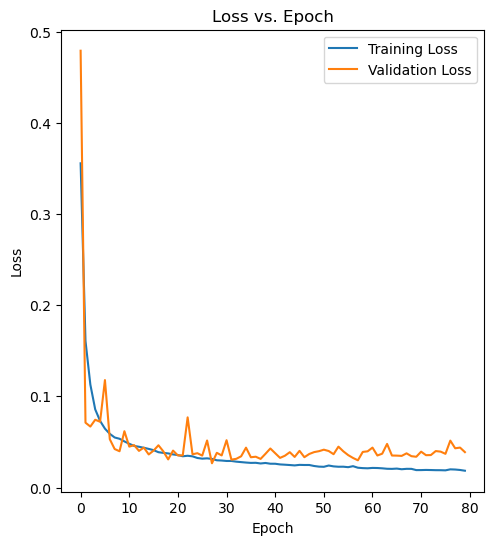

In [19]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_SA_UNet_model_32b_80epch_005lr', 'rb') as history_file:
    history = pickle.load(history_file)

import matplotlib.pyplot as plt

# Eğitim geçmişini görselleştirme
# İki grafik için subplot oluşturun
plt.figure(figsize=(12, 6))

# Eğitim ve doğrulama kayıplarını ilk grafikte çizin
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()
